In [119]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [120]:
data = pd.read_csv("../data/external/ihsg 14-12-22 till 22-04-24.csv")
# data = pd.read_csv("../data/external/5 tahun.csv")
sentiment = pd.read_csv("../data/processed/preprocces-data.csv")

data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-12-14,6810.355957,6854.098145,6774.131836,6801.749023,6801.749023,215430000
1,2022-12-15,6801.789063,6801.837891,6740.955078,6751.859863,6751.859863,145093400
2,2022-12-16,6751.859863,6812.192871,6693.765137,6812.192871,6812.192871,156126900
3,2022-12-19,6812.153809,6827.814941,6754.087891,6779.698242,6779.698242,127896600
4,2022-12-20,6779.698242,6792.203125,6715.044922,6768.315918,6768.315918,151817000


In [121]:
data.columns = data.columns.str.strip()
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       319 non-null    object 
 1   Open       319 non-null    float64
 2   High       319 non-null    float64
 3   Low        319 non-null    float64
 4   Close      319 non-null    float64
 5   Adj Close  319 non-null    float64
 6   Volume     319 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 17.6+ KB


In [123]:
# Menghitung return manual berdasarkan harga penutupan (Close)
data['Return'] = (data['Close'] - data['Close'].shift(1)) / data['Close'].shift(1) * 100


In [124]:
sentiment


sentiment_mapping = {"positive": 0, "negative": 1, "neutral": 2}

data['Sentiment'] = sentiment['sentiment'].map(sentiment_mapping)

In [125]:
lengh_data = len(data)
split_ratio = 0.8
lengh_train = round(lengh_data * split_ratio)
lengh_validation = lengh_data -lengh_train

In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       319 non-null    object 
 1   Open       319 non-null    float64
 2   High       319 non-null    float64
 3   Low        319 non-null    float64
 4   Close      319 non-null    float64
 5   Adj Close  319 non-null    float64
 6   Volume     319 non-null    int64  
 7   Return     318 non-null    float64
 8   Sentiment  319 non-null    int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 22.6+ KB


In [127]:
data = data.drop(["Volume"],axis=1)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index("Date")



In [128]:
lengh_data = len(data)
split_ratio = 0.8
lengh_train = round(lengh_data * split_ratio)
lengh_validation = lengh_data -lengh_train

In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 319 entries, 2022-12-14 to 2024-04-19
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       319 non-null    float64
 1   High       319 non-null    float64
 2   Low        319 non-null    float64
 3   Close      319 non-null    float64
 4   Adj Close  319 non-null    float64
 5   Return     318 non-null    float64
 6   Sentiment  319 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 19.9 KB


In [130]:
# data_supervised

In [131]:
# # Fungsi untuk mengubah data time series menjadi supervised learning
# def time_series_to_supervised(data, n_in=1, n_out=1, dropnan=True, var_names=None):
#     n_vars = 1 if type(data) is list else data.shape[1]
#     df = pd.DataFrame(data)
#     cols, names = [], []

#     # Input sequence (t-n, ... t-1)
#     for i in range(n_in, 0, -1):
#         cols.append(df.shift(i))
#         if var_names is None:
#             names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
#         else:
#             names += [(var_names[j] + '(t-%d)' % i) for j in range(n_vars)]

#     # Output sequence (t, t+1, ... t+n)
#     for i in range(0, n_out):
#         cols.append(df.shift(-i))
#         if i == 0:
#             if var_names is None:
#                 names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
#             else:
#                 names += [(var_names[j] + '(t)') for j in range(n_vars)]
#         else:
#             if var_names is None:
#                 names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
#             else:
#                 names += [(var_names[j] + '(t+%d)' % i) for j in range(n_vars)]

#     # Concatenate semua kolom
#     agg = pd.concat(cols, axis=1)
#     agg.columns = names

#     # Hapus baris dengan nilai NaN
#     if dropnan:
#         agg.dropna(inplace=True)

#     return agg

# # Mengubah data time series menjadi format supervised learning
# var_names = data.columns
# data_supervised = time_series_to_supervised(data, n_in=15, n_out=1, var_names=var_names)

def time_series_to_supervised(data, n_in=1, n_out=1, dropnan=True, var_names=None):
    """
    Mengubah data time series menjadi data supervised learning.

    Argumen:
    data: DataFrame, dataset time series yang akan diubah.
    n_in: int, jumlah timestep mundur sebagai input (X).
    n_out: int, jumlah timestep maju sebagai output (y).
    dropnan: bool, apakah akan menghapus baris dengan nilai NaN.
    var_names: list of str, nama variabel untuk setiap kolom.

    Returns:
    DataFrame yang sudah diubah menjadi format supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        if var_names is None:
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        else:
            names += [(var_names[j] + '(t-%d)' % i) for j in range(n_vars)]

    # Output sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            if var_names is None:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [(var_names[j] + '(t)') for j in range(n_vars)]
        else:
            if var_names is None:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            else:
                names += [(var_names[j] + '(t+%d)' % i) for j in range(n_vars)]

    # Concatenate semua kolom
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # Hapus baris dengan nilai NaN
    if dropnan:
        agg.dropna(inplace=True)

    return agg


In [132]:
# train_data = data_supervised[:lengh_train]
# validation_data = data_supervised[lengh_train:]

# Contoh penggunaan: konversi data time series ke supervised
var_names = data.columns

# Pastikan data dalam format numerik: ubah koma menjadi titik dan tipe data ke float
data = data.replace(',', '.', regex=True).astype(float)

# Konversi data time series menjadi supervised learning
data_supervised = time_series_to_supervised(data, n_in=15, n_out=1, var_names=var_names)

# Pisahkan data menjadi train dan validation
length_train = int(0.8 * len(data_supervised))  # Misalnya 80% untuk train
train_data = data_supervised[:length_train]
validation_data = data_supervised[length_train:]

In [133]:
# train_data = data_supervised[:lengh_train]
# validation_data = data_supervised[lengh_train:]

In [134]:

# data_supervised

In [135]:
from sklearn.preprocessing import MinMaxScaler

# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

# Normalisasi data train
scaled_train_data = scaler.fit_transform(train_data)

# Konversi hasil normalisasi kembali menjadi DataFrame
scaled_train_data = pd.DataFrame(scaled_train_data, columns=train_data.columns)


In [136]:
scaled_train_data

,Open(t-15),High(t-15),Low(t-15),Close(t-15),Adj Close(t-15),Return(t-15),Sentiment(t-15),Open(t-14),High(t-14),Low(t-14),...,Adj Close(t-1),Return(t-1),Sentiment(t-1),Open(t),High(t),Low(t),Close(t),Adj Close(t),Return(t),Sentiment(t)
0,0.411580,0.309317,0.341516,0.304990,0.304990,0.396253,0.5,0.301467,0.319313,0.240926,...,0.311713,0.306744,0.0,0.305408,0.244148,0.098034,0.110968,0.110968,0.000000,0.5
1,0.324527,0.327206,0.260189,0.403850,0.403850,0.797686,0.5,0.399121,0.345651,0.337190,...,0.110968,0.000000,0.5,0.108606,0.109944,0.069141,0.149653,0.149653,0.691119,1.0
2,0.429652,0.354195,0.364149,0.350605,0.350605,0.459530,0.5,0.346555,0.285612,0.274884,...,0.149653,0.691119,1.0,0.146602,0.133418,0.118657,0.154322,0.154322,0.590902,0.5
3,0.373064,0.292671,0.296862,0.331955,0.331955,0.535797,0.5,0.328120,0.333593,0.352524,...,0.154322,0.590902,0.5,0.151176,0.086367,0.033981,0.071497,0.071497,0.334614,0.5
4,0.353219,0.341839,0.380709,0.417729,0.417729,0.768039,0.5,0.412966,0.373142,0.411442,...,0.071497,0.334614,0.5,0.070089,0.000000,0.018727,0.023582,0.023582,0.435478,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,0.991888,1.000000,1.000000,0.973098,0.973098,0.663586,1.0,0.928941,0.894086,0.801708,...,0.954441,0.749524,1.0,0.925756,0.895362,0.907474,0.898402,0.898402,0.427313,0.0
238,1.000000,0.916187,0.865808,0.857066,0.857066,0.333193,0.0,0.873382,0.862231,0.861882,...,0.898402,0.427313,0.0,0.893625,0.958576,0.913085,1.000000,1.000000,0.850658,0.0
239,0.940190,0.883544,0.930793,0.916910,0.916910,0.704333,1.0,0.881650,0.845801,0.802937,...,1.000000,0.850658,0.0,1.000000,1.000000,1.000000,0.988484,0.988484,0.546565,1.0
240,0.949091,0.866708,0.867135,0.835036,0.835036,0.404204,1.0,0.920464,0.958226,0.913852,...,0.988484,0.546565,1.0,0.982430,0.986621,0.906603,0.904050,0.904050,0.352186,0.0


In [137]:
# Target (Return(t)) dan input (X) untuk training
y_train_scaled = scaled_train_data[["Return(t)"]]  # Ambil kolom Return(t) sebagai target
X_train_scaled = scaled_train_data.drop(["Open(t)", "Close(t)", "High(t)", "Low(t)", "Adj Close(t)", "Sentiment(t)", "Return(t)"], axis=1)


In [138]:
X_train_scaled

,Open(t-15),High(t-15),Low(t-15),Close(t-15),Adj Close(t-15),Return(t-15),Sentiment(t-15),Open(t-14),High(t-14),Low(t-14),...,Adj Close(t-2),Return(t-2),Sentiment(t-2),Open(t-1),High(t-1),Low(t-1),Close(t-1),Adj Close(t-1),Return(t-1),Sentiment(t-1)
0,0.411580,0.309317,0.341516,0.304990,0.304990,0.396253,0.5,0.301467,0.319313,0.240926,...,0.406821,0.713254,1.0,0.398577,0.355807,0.334783,0.311713,0.311713,0.306744,0.0
1,0.324527,0.327206,0.260189,0.403850,0.403850,0.797686,0.5,0.399121,0.345651,0.337190,...,0.311713,0.306744,0.0,0.305408,0.244148,0.098034,0.110968,0.110968,0.000000,0.5
2,0.429652,0.354195,0.364149,0.350605,0.350605,0.459530,0.5,0.346555,0.285612,0.274884,...,0.110968,0.000000,0.5,0.108606,0.109944,0.069141,0.149653,0.149653,0.691119,1.0
3,0.373064,0.292671,0.296862,0.331955,0.331955,0.535797,0.5,0.328120,0.333593,0.352524,...,0.149653,0.691119,1.0,0.146602,0.133418,0.118657,0.154322,0.154322,0.590902,0.5
4,0.353219,0.341839,0.380709,0.417729,0.417729,0.768039,0.5,0.412966,0.373142,0.411442,...,0.154322,0.590902,0.5,0.151176,0.086367,0.033981,0.071497,0.071497,0.334614,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,0.991888,1.000000,1.000000,0.973098,0.973098,0.663586,1.0,0.928941,0.894086,0.801708,...,0.890475,0.472193,1.0,0.866894,0.897551,0.869956,0.954441,0.954441,0.749524,1.0
238,1.000000,0.916187,0.865808,0.857066,0.857066,0.333193,0.0,0.873382,0.862231,0.861882,...,0.954441,0.749524,1.0,0.925756,0.895362,0.907474,0.898402,0.898402,0.427313,0.0
239,0.940190,0.883544,0.930793,0.916910,0.916910,0.704333,1.0,0.881650,0.845801,0.802937,...,0.898402,0.427313,0.0,0.893625,0.958576,0.913085,1.000000,1.000000,0.850658,0.0
240,0.949091,0.866708,0.867135,0.835036,0.835036,0.404204,1.0,0.920464,0.958226,0.913852,...,1.000000,0.850658,0.0,1.000000,1.000000,1.000000,0.988484,0.988484,0.546565,1.0


In [139]:
y_train_scaled

,Return(t)
0,0.000000
1,0.691119
2,0.590902
3,0.334614
4,0.435478
...,...
237,0.427313
238,0.850658
239,0.546565
240,0.352186


In [140]:
import optuna

# Initialize Optuna study
study = optuna.create_study(direction="minimize")


[I 2024-11-06 13:49:08,934] A new study created in memory with name: no-name-0af137a8-54ba-4d05-b3b7-99cdf4095104


In [141]:
# Define the optimization loop
for _ in range(100):  # Adjust the number of trials as needed
    trial = study.ask()
    
    # Suggest parameters for this trial
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 0.1)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_child_weight = trial.suggest_loguniform("min_child_weight", 1e-2, 10)
    gamma = trial.suggest_loguniform("gamma", 1e-4, 1.0)
    subsample = trial.suggest_uniform("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.5, 1.0)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-4, 1.0)

    # Create the model with the suggested parameters
    model_xgb = xgb.XGBRegressor(
        objective="reg:squarederror",
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=reg_lambda,
        random_state=42
    )

C:\Users\rizki\AppData\Local\Temp\ipykernel_3024\3590045820.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 0.1)
C:\Users\rizki\AppData\Local\Temp\ipykernel_3024\3590045820.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  min_child_weight = trial.suggest_loguniform("min_child_weight", 1e-2, 10)
C:\Users\rizki\AppData\Local\Temp\ipykernel_3024\3590045820.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform("gam

In [142]:


# # model_xgb = xgb.XGBRegressor(objective='reg:squarederror', reg_lambda=0.002, gamma=0.1, max_depth=5, n_estimators=500, learning_rate=0.01, random_state=42)
# model_xgb = xgb.XGBRegressor(
#     learning_rate=0.01, 
#     n_estimators=500, 
#     max_depth=5, 
#     min_child_weight=1, 
#     gamma=0.1, 
#     subsample=0.8, 
#     colsample_bytree=0.8
# )

model_xgb.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9840939450451355, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.00033262853585477273,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.004312634517156048,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=0.43790101707475304, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=797,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [143]:
y_pred = model_xgb.predict(X_train_scaled)

    

In [144]:
# from xgboost import plot_importance
# import matplotlib.pyplot as plt

# # Plot feature importance dengan hanya menampilkan 10 fitur teratas
# plot_importance(model_xgb, importance_type='weight', max_num_features=30)
# plt.show()


In [145]:
total_features = len(model_xgb.feature_importances_)
print(f"Total number of features: {total_features}")


Total number of features: 105


In [146]:
y_pred

array([0.07511827, 0.6810006 , 0.58027714, 0.37606588, 0.45543882,
       0.73419833, 0.6066705 , 0.7263151 , 0.83937097, 0.58156884,
       0.75650555, 0.75363886, 0.5318592 , 0.48606962, 0.6759369 ,
       0.6591913 , 0.5029278 , 0.49048963, 0.6505348 , 0.6578546 ,
       0.6215231 , 0.4824994 , 0.74188316, 0.59314424, 0.45160246,
       0.52676564, 0.6276848 , 0.67194486, 0.49746695, 0.5202971 ,
       0.59106356, 0.5820217 , 0.5363203 , 0.41244987, 0.6671446 ,
       0.6201055 , 0.5617046 , 0.5448022 , 0.5790403 , 0.60865366,
       0.4705312 , 0.5489518 , 0.49682477, 0.61263436, 0.6273468 ,
       0.4905016 , 0.6342592 , 0.15571527, 0.54058284, 0.40917283,
       0.9387044 , 0.37960297, 0.8419109 , 0.81152284, 0.42858982,
       0.7450171 , 0.81380224, 0.50154406, 0.57150936, 0.6601535 ,
       0.5950071 , 0.53105664, 0.5067117 , 0.51637936, 0.6861    ,
       0.5472982 , 0.5257727 , 0.6885567 , 0.5132892 , 0.65518516,
       0.81748474, 0.65140086, 0.49667916, 0.44638938, 0.45039

In [147]:
mse = np.mean((y_pred - scaled_train_data['Return(t)'])**2)

# Menghitung Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 0.0011643351389005407
RMSE: 0.03412235541255235


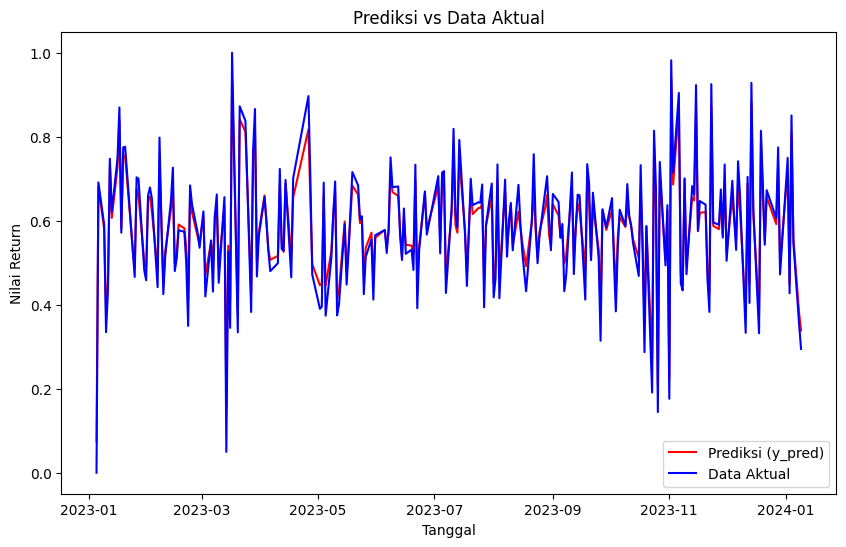

In [148]:
# Plot hasil prediksi (y_pred) dan data aktual (train_data['Return(t)'])
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, y_pred, label='Prediksi (y_pred)', color='red')
plt.plot(train_data.index, scaled_train_data['Return(t)'], label='Data Aktual', color='blue')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Return')
plt.title('Prediksi vs Data Aktual')
plt.legend()
plt.show()



In [149]:
scaled_val_data = scaler.fit_transform(validation_data)

# Konversi data yang telah dinormalisasi kembali ke dalam DataFrame
scaled_val_data = pd.DataFrame(scaled_val_data, columns=validation_data.columns)

In [150]:
scaled_val_data

,Open(t-15),High(t-15),Low(t-15),Close(t-15),Adj Close(t-15),Return(t-15),Sentiment(t-15),Open(t-14),High(t-14),Low(t-14),...,Adj Close(t-1),Return(t-1),Sentiment(t-1),Open(t),High(t),Low(t),Close(t),Adj Close(t),Return(t),Sentiment(t)
0,0.217831,0.171140,0.258022,0.227741,0.227741,0.598754,1.0,0.212222,0.091056,0.000000,...,0.229316,0.178495,1.0,0.195260,0.377221,0.327909,0.404569,0.404569,0.690139,0.5
1,0.212222,0.091056,0.000000,0.000000,0.000000,0.155625,1.0,0.000000,0.073521,0.069304,...,0.318890,0.690139,0.5,0.421115,0.434433,0.516456,0.383375,0.383375,0.529424,1.0
2,0.000000,0.073521,0.069304,0.217729,0.217729,0.875520,0.5,0.296427,0.247694,0.347397,...,0.294647,0.529424,1.0,0.383097,0.416442,0.476533,0.444573,0.444573,0.662213,1.0
3,0.296427,0.247694,0.347397,0.319137,0.319137,0.685015,1.0,0.345200,0.217537,0.269948,...,0.364651,0.662213,1.0,0.423134,0.446452,0.478074,0.395043,0.395043,0.483942,0.0
4,0.345200,0.217537,0.269948,0.287116,0.287116,0.470576,1.0,0.356736,0.284468,0.420513,...,0.307994,0.483942,0.0,0.346316,0.404635,0.488534,0.449338,0.449338,0.651037,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.945267,1.000000,0.962120,1.000000,1.000000,0.581992,1.0,0.955378,0.867565,0.720064,...,0.408491,0.974521,1.0,0.393226,0.502698,0.570728,0.576781,0.576781,0.714184,1.0
57,0.955378,0.867565,0.720064,0.664550,0.664550,0.000000,0.5,0.724533,0.666743,0.696415,...,0.515882,0.714184,1.0,0.000000,0.148650,0.085348,0.223961,0.223961,0.000000,0.0
58,0.724533,0.666743,0.696415,0.582951,0.582951,0.393097,0.5,0.667173,0.677095,0.740549,...,0.112295,0.000000,0.0,0.237259,0.296589,0.265974,0.125792,0.125792,0.404079,0.5
59,0.667173,0.677095,0.740549,0.692250,0.692250,0.694951,1.0,0.612853,0.614300,0.677778,...,0.000000,0.404079,0.5,0.072375,0.124583,0.279125,0.229762,0.229762,0.733259,0.0


In [151]:
y_val_scaled = scaled_val_data[["Return(t)"]]  # Ambil kolom Open(t) sebagai target
X_val_scaled = scaled_val_data.drop(["Open(t)", "Close(t)", "High(t)", "Low(t)", "Adj Close(t)","Sentiment(t)","Return(t)"], axis=1)

In [152]:
y_val_pred = model_xgb.predict(X_val_scaled)

In [153]:
import numpy as np

# Cari indeks kolom target di train_data untuk memastikan kita menggunakan scaler yang benar
target_col_index = train_data.columns.get_loc("Return(t)")

# Ambil informasi skala dari scaler pada kolom target
target_min = scaler.data_min_[target_col_index]
target_max = scaler.data_max_[target_col_index]
target_scale = scaler.scale_[target_col_index]

# Denormalisasi y_val_pred
y_val_pred_original = y_val_pred * (target_max - target_min) + target_min


In [154]:
validation_data

,Open(t-15),High(t-15),Low(t-15),Close(t-15),Adj Close(t-15),Return(t-15),Sentiment(t-15),Open(t-14),High(t-14),Low(t-14),...,Adj Close(t-1),Return(t-1),Sentiment(t-1),Open(t),High(t),Low(t),Close(t),Adj Close(t),Return(t),Sentiment(t)
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-10,7183.148926,7215.937012,7169.430176,7190.987793,7190.987793,0.208635,2.0,7181.434082,7192.892090,7092.027832,...,7200.203125,-1.144659,2.0,7187.580078,7259.601074,7152.877930,7227.296875,7227.296875,0.376291,1.0
2024-01-11,7181.434082,7192.892090,7092.027832,7119.524902,7119.524902,-0.993784,2.0,7116.545898,7187.846191,7112.817871,...,7227.296875,0.376291,1.0,7253.456055,7277.500977,7219.963867,7219.963867,7219.963867,-0.101463,2.0
2024-01-12,7116.545898,7187.846191,7112.817871,7187.846191,7187.846191,0.959633,1.0,7207.180176,7237.965820,7196.241211,...,7219.963867,-0.101463,2.0,7242.367188,7271.872070,7205.758789,7241.138184,7241.138184,0.293275,2.0
2024-01-15,7207.180176,7237.965820,7196.241211,7219.666992,7219.666992,0.442703,2.0,7222.092773,7229.288086,7173.007813,...,7241.138184,0.293275,2.0,7254.044922,7281.261230,7206.307129,7224.000977,7224.000977,-0.236665,0.0
2024-01-16,7222.092773,7229.288086,7173.007813,7209.619141,7209.619141,-0.139173,2.0,7225.620117,7248.547852,7218.174805,...,7224.000977,-0.236665,0.0,7231.639160,7268.178223,7210.028809,7242.787109,7242.787109,0.260052,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-05,7405.566895,7454.448242,7380.647949,7433.314941,7433.314941,0.163153,2.0,7408.658203,7416.338867,7308.035156,...,7254.398926,1.221663,2.0,7245.321777,7298.858887,7239.273926,7286.881836,7286.881836,0.447768,2.0
2024-04-16,7408.658203,7416.338867,7308.035156,7328.054199,7328.054199,-1.416067,1.0,7338.076172,7358.550781,7300.940918,...,7286.881836,0.447768,2.0,7130.627930,7188.088867,7066.573242,7164.807129,7164.807129,-1.675267,0.0
2024-04-17,7338.076172,7358.550781,7300.940918,7302.449219,7302.449219,-0.349410,1.0,7320.538086,7361.529785,7314.180176,...,7164.807129,-1.675267,0.0,7199.830078,7234.374023,7130.840820,7130.840820,7130.840820,-0.474072,1.0


In [155]:
mse = np.mean((y_val_pred_original - validation_data['Return(t)'])**2)
    
# Menghitung Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 0.4656159437034772
RMSE: 0.6823605672248926


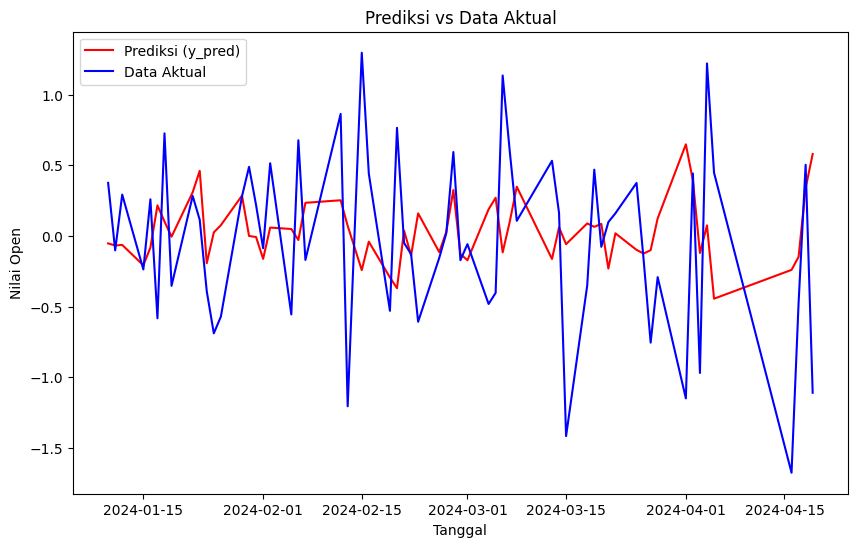

In [156]:
import matplotlib.pyplot as plt

# Plot hasil prediksi (y_pred) dan data aktual (train_data['Open(t)'])
plt.figure(figsize=(10, 6))
plt.plot(validation_data.index, y_val_pred_original, label='Prediksi (y_pred)', color='red')
plt.plot(validation_data.index, validation_data['Return(t)'], label='Data Aktual', color='blue')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Open')
plt.title('Prediksi vs Data Aktual')
plt.legend()
plt.show()